# Initial-data-exploration

This notebook represents the initial deep dive into data to come up with a plan how to use the given data to produce required results. For saving the time, I will summarize my findings from EDA just below, please follow the below code if you want to follow along.

# Summary

## 1.  Similarity Measure

Looking at the dataset, we have following broader ways to find similar users.

1.	Similarity based on interests
2.	Similarity based on user interaction with the platform (Assessment Scores and Course view time)
3. A combination of above two


## 2. Overall Consume Time

Why look at overall consume time? I am assuming one of the business objectives of Pluralsight should be to increase the overall consume time of the platform. From my understanding this particular project can fit in the overall strategy map of the organisation by understanding users better and assisting in better learning. IMO, one of the online metric for measuring the success of the project should be aligned with Overall Consume time of the platform.

### Most of the consume time(more than 95%) of the platform is coming from Beginner and Intermediate level courses.

Note: The tags "course_tags", "assessment_tag" and "interest_tag" will add huge value in finding similarity but as this is real world data, it is messy. From my past experience, a fuzzy matching can do the job but it will require careful consideration and investment of time for mapping the data. For instance, a quick analysis of interest tags show that we can have a better grouping of tags and it can improve our similaraity calculations substantially. e.g., javascript has many similar tags like "javascript", "javascript-framework" and "javascript-libraries". However, we have to be very careful in terms of fuzzy matching of the tags reason being it can easily pollute the data. e.g. "java" and "javascript" tags should not be considered similar however if we just go by the text matching. Therefore, as MVP for this task, I will not use the combined tags info to start with. However, if time permits later, I would love to come back and give it a shot.

## 3. Feature Engineering

There is a lot of possibility of creating features and using them to improve model performance. If time permits, it will be fun to experiment with some of following:

- Total Course view time for individual user
- Number of course a user has viewed
- Total number authors a user consumed courses for
- Number of level of courses(Beginner, Intermediate, Advanced) a user has watched


In [1]:
import os
import sys
import pandas as pd
import matplotlib as plt
%matplotlib inline
import pandas_profiling as pp

In [2]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Data Ingestion

In [3]:
from paths import course_tags_file, user_assessment_scores_file, user_course_views_file, interests_file

In [4]:
file_paths=[course_tags_file, user_assessment_scores_file, user_course_views_file, interests_file]
file_paths

['/Users/skumar/projects/personal/pluralsight-recommender/data/raw/course_tags.csv',
 '/Users/skumar/projects/personal/pluralsight-recommender/data/raw/user_assessment_scores.csv',
 '/Users/skumar/projects/personal/pluralsight-recommender/data/raw/user_course_views.csv',
 '/Users/skumar/projects/personal/pluralsight-recommender/data/raw/user_interests.csv']

In [5]:
raw_course_tags_df=pd.read_csv(file_paths[0])
raw_user_assessment_scores_df=pd.read_csv(file_paths[1])
raw_user_course_views_df=pd.read_csv(file_paths[2])
raw_user_interests_df=pd.read_csv(file_paths[3])

## Data Overview

In [6]:
pp.ProfileReport(raw_user_assessment_scores_df)

In [7]:
pp.ProfileReport(raw_user_course_views_df)

In [8]:
pp.ProfileReport(raw_course_tags_df)

In [9]:
pp.ProfileReport(raw_user_interests_df)

In [10]:
raw_course_tags_df.isnull().sum()

course_id        0
course_tags    112
dtype: int64

In [11]:
raw_course_tags_df['course_tags'].fillna('missing', inplace=True)

In [12]:
raw_user_course_views_df.head()

user_handle   view_date                                       course_id  \
0            1  2017-06-27         cpt-sp2010-web-designers-branding-intro   
1            1  2017-06-28         cpt-sp2010-web-designers-branding-intro   
2            1  2017-06-28                    cpt-sp2010-web-designers-css   
3            1  2017-07-27                    cpt-sp2010-web-designers-css   
4            1  2017-09-12  aws-certified-solutions-architect-professional   

   author_handle         level  view_time_seconds  
0            875      Beginner               3786  
1            875      Beginner               1098  
2            875  Intermediate               4406  
3            875  Intermediate                553  
4            281      Advanced                102

In [13]:
raw_user_course_views_df.shape

(249238, 6)

In [14]:
raw_user_course_views_df.head()

user_handle   view_date                                       course_id  \
0            1  2017-06-27         cpt-sp2010-web-designers-branding-intro   
1            1  2017-06-28         cpt-sp2010-web-designers-branding-intro   
2            1  2017-06-28                    cpt-sp2010-web-designers-css   
3            1  2017-07-27                    cpt-sp2010-web-designers-css   
4            1  2017-09-12  aws-certified-solutions-architect-professional   

   author_handle         level  view_time_seconds  
0            875      Beginner               3786  
1            875      Beginner               1098  
2            875  Intermediate               4406  
3            875  Intermediate                553  
4            281      Advanced                102

In [15]:
raw_user_interests_df.head()

user_handle      interest_tag        date_followed
0            1   mvc-scaffolding  2017-06-27 16:26:52
1            1              mvc2  2017-06-27 16:26:52
2            1  mvc-html-helpers  2017-06-27 16:26:52
3            1          mvc4-ioc  2017-06-27 16:26:52
4            1       mvc-testing  2017-06-27 16:26:52

In [16]:
raw_user_course_views_df.head()

user_handle   view_date                                       course_id  \
0            1  2017-06-27         cpt-sp2010-web-designers-branding-intro   
1            1  2017-06-28         cpt-sp2010-web-designers-branding-intro   
2            1  2017-06-28                    cpt-sp2010-web-designers-css   
3            1  2017-07-27                    cpt-sp2010-web-designers-css   
4            1  2017-09-12  aws-certified-solutions-architect-professional   

   author_handle         level  view_time_seconds  
0            875      Beginner               3786  
1            875      Beginner               1098  
2            875  Intermediate               4406  
3            875  Intermediate                553  
4            281      Advanced                102

## Data Summary

In [17]:
print("Number of records in user_interests.csv: ", raw_user_interests_df.shape)
print("Number of records in course_tags.csv: ", raw_course_tags_df.shape)
print("Number of records in user_assessment_scores.csv: ", raw_user_assessment_scores_df.shape)
print("Number of records in user_course_views.csv: ", raw_user_course_views_df.shape)

Number of records in user_interests.csv:  (297526, 3)
Number of records in course_tags.csv:  (11337, 2)
Number of records in user_assessment_scores.csv:  (6571, 4)
Number of records in user_course_views.csv:  (249238, 6)


In [18]:
print("Number of unique users: ", raw_user_interests_df.user_handle.nunique())
print("Number of unique courses: ", raw_course_tags_df.course_id.nunique())
print("Number of users with assessment scores: ", raw_user_assessment_scores_df.user_handle.nunique())
print("Number of users with course views: ", raw_user_course_views_df.user_handle.nunique())

Number of unique users:  10000
Number of unique courses:  5942
Number of users with assessment scores:  3114
Number of users with course views:  8760


## Missing Value Analysis

In [19]:
raw_user_interests_df.isnull().sum()

user_handle      0
interest_tag     0
date_followed    0
dtype: int64

In [20]:
raw_course_tags_df.isnull().sum()

course_id      0
course_tags    0
dtype: int64

In [21]:
raw_user_assessment_scores_df.isnull().sum()

user_handle              0
assessment_tag           0
user_assessment_date     0
user_assessment_score    0
dtype: int64

In [22]:
raw_user_course_views_df.isnull().sum()

user_handle          0
view_date            0
course_id            0
author_handle        0
level                0
view_time_seconds    0
dtype: int64

In [23]:
missing_tag_courses=raw_course_tags_df.loc[raw_course_tags_df.course_tags.isnull()].course_id

In [24]:
sum_miss_tags_courses=raw_user_course_views_df[raw_user_course_views_df.course_id.isin(missing_tag_courses)].view_time_seconds.sum()
sum_miss_tags_courses

0

In [25]:
total_consume_time=raw_user_course_views_df.view_time_seconds.sum()
total_consume_time

445568386

In [26]:
print("Contribution of courses with no tags in overall platform consume time: ", sum_miss_tags_courses/total_consume_time)

Contribution of courses with no tags in overall platform consume time:  0.0


Only file with null values is course_tags.csv with 112 courses with no tags which approximately 1.9%(112/5942) of total course catalog. My initial thought was probably the courses with no tags may be less popular than others but checking the course view time in course_view csv file indicates otherwise. Contribution of these courses in total consume time of the platform is around ~1.3%.

## Overall Consume Time

In [27]:
raw_user_course_views_df.groupby(["level"]).view_time_seconds.sum()/total_consume_time

level
Advanced        0.047544
Beginner        0.477101
Intermediate    0.475355
Name: view_time_seconds, dtype: float64

## Data Time Analysis


In [28]:
raw_user_course_views_df['view_date']=pd.to_datetime(raw_user_course_views_df.view_date)
raw_user_interests_df['date_followed']=pd.to_datetime(raw_user_interests_df.date_followed)
raw_user_assessment_scores_df['user_assessment_date']=pd.to_datetime(raw_user_assessment_scores_df.user_assessment_date)

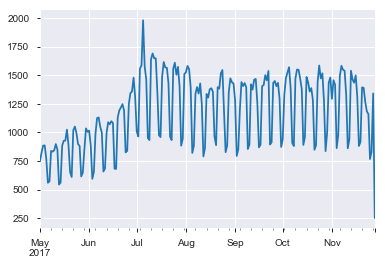

In [29]:
raw_user_course_views_df.view_date.value_counts().sort_index().plot()

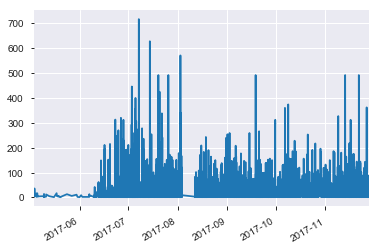

In [30]:
raw_user_interests_df.date_followed.value_counts().sort_index().plot()

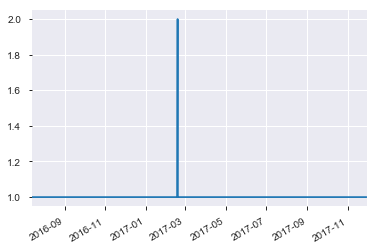

In [31]:
raw_user_assessment_scores_df.user_assessment_date.value_counts().sort_index().plot()

In [32]:
raw_user_assessment_scores_df.user_assessment_date.min()

Timestamp('2016-07-13 15:30:44')

In [33]:
raw_user_assessment_scores_df.user_assessment_date.max()

Timestamp('2017-11-28 19:34:32')


Provided data is for 7 months for "view time" and "date_followed" and a little over 16 months for "user_assessment_date".

In [34]:
num_users=raw_user_course_views_df['user_handle'].value_counts()

In [35]:
raw_user_course_views_df.head()

user_handle  view_date                                       course_id  \
0            1 2017-06-27         cpt-sp2010-web-designers-branding-intro   
1            1 2017-06-28         cpt-sp2010-web-designers-branding-intro   
2            1 2017-06-28                    cpt-sp2010-web-designers-css   
3            1 2017-07-27                    cpt-sp2010-web-designers-css   
4            1 2017-09-12  aws-certified-solutions-architect-professional   

   author_handle         level  view_time_seconds  
0            875      Beginner               3786  
1            875      Beginner               1098  
2            875  Intermediate               4406  
3            875  Intermediate                553  
4            281      Advanced                102

# Plot of most active users

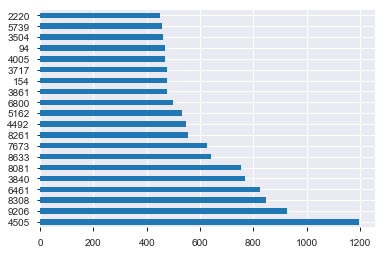

In [36]:
num_users[:20].plot(kind='barh')

In [37]:
compact_course_tags_df=raw_course_tags_df.copy()

In [38]:
compact_course_tags_df=compact_course_tags_df.groupby('course_id')['course_tags'].apply(lambda x: ','.join(x)).reset_index()


In [39]:
def remove_duplicates(words):
    unique_word_list=list(set(words.split(',')))
    return ','.join(unique_word_list)
    

In [40]:
unique_course_tags_df=compact_course_tags_df.copy()

In [41]:
unique_course_tags_df['course_tags']=unique_course_tags_df['course_tags'].apply(remove_duplicates)

In [42]:
unique_course_tags_df.head()

course_id  \
0     12-principles-animation-toon-boom-harmony-1475   
1                 2d-racing-game-series-unity-5-1312   
2                2d-racing-games-unity-volume-2-1286   
3                2d-racing-games-unity-volume-4-1311   
4  3d-coat-character-concept-sculpting-techniques...   

                                         course_tags  
0                                       2d-animation  
1                                        game-design  
2  image-editing,creative-pipeline,art-and-design...  
3                       game-programming,game-design  
4  character-modeling,3d-sculpting,character-scul...

# User Course View Analysis

In [43]:
raw_user_course_views_df.head()

user_handle  view_date                                       course_id  \
0            1 2017-06-27         cpt-sp2010-web-designers-branding-intro   
1            1 2017-06-28         cpt-sp2010-web-designers-branding-intro   
2            1 2017-06-28                    cpt-sp2010-web-designers-css   
3            1 2017-07-27                    cpt-sp2010-web-designers-css   
4            1 2017-09-12  aws-certified-solutions-architect-professional   

   author_handle         level  view_time_seconds  
0            875      Beginner               3786  
1            875      Beginner               1098  
2            875  Intermediate               4406  
3            875  Intermediate                553  
4            281      Advanced                102

## Number of Courses a User viewed

In [44]:
compact_user_course_view_df=raw_user_course_views_df.groupby('user_handle').agg({'course_id':'count'}).reset_index().rename(columns={'course_id': 'course_view_count'})

In [50]:
compact_user_course_view_df.sort_values(by=['course_view_count'], ascending=False).head(10)

user_handle  course_view_count
3958         4505               1197
8068         9206                926
7274         8308                847
5668         6461                824
3365         3840                769
7072         8081                752
7557         8633                640
6719         7673                627
7232         8261                554
3948         4492                549

In [62]:
user_course_view_time_df=raw_user_course_views_df.groupby(
    ['user_handle', 'course_id']).agg(
    {'view_time_seconds': 'sum'}).reset_index().sort_values(
    by='view_time_seconds', ascending=False)

In [90]:
user_course_view_time_df[user_course_view_time_df.view_time_seconds<=300].shape

(25784, 3)

A lot of user item interaction resulted in less than 5 minutes of view time. One of the following two may have happened:
- User may have clicked a course by mistake
- User did not like the course